In [1]:
from matplotlib import pyplot as plt
from jupyter_plotter import plot_jupyter_figure
import pymatching

from circuit_generators import get_builtin_circuit, get_custom_circuit
from sampling_functions import create_task_sinter, generate_samples_sinter, get_variable_from_sample_sinter, plot_error_rate_sinter

# Also define the number of worker nodes here
n_worker_nodes = 8

saved_data_dir = "rcnn_d4_r4"

In [2]:
n_samples = 10000000
decoders = ['pymatching']
distances = [3, 4, 5, 6]
rounds = distances
noise_levels = [0.01]

noise = noise_levels[0]

# Uses sinter's task function to perform fast montecarlo sampling 
# A sinter task takes a stim circuit and wraps it for sinter to sample from
tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {
      "builtin_name": "surface_code:rotated_memory_z", "distance": distances[idx], "rounds": rounds[idx],
      "after_reset_flip_probability": noise,
      "after_clifford_depolarization": noise,
      "before_round_data_depolarization": noise,
      "before_measure_flip_probability": noise,
      },
    json_metadata = {'distance': distances[idx], 'noise': noise, 'rounds': rounds[idx]}
  )
  for idx in range(len(distances))
]

results = generate_samples_sinter(
  num_workers = n_worker_nodes,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples,
)

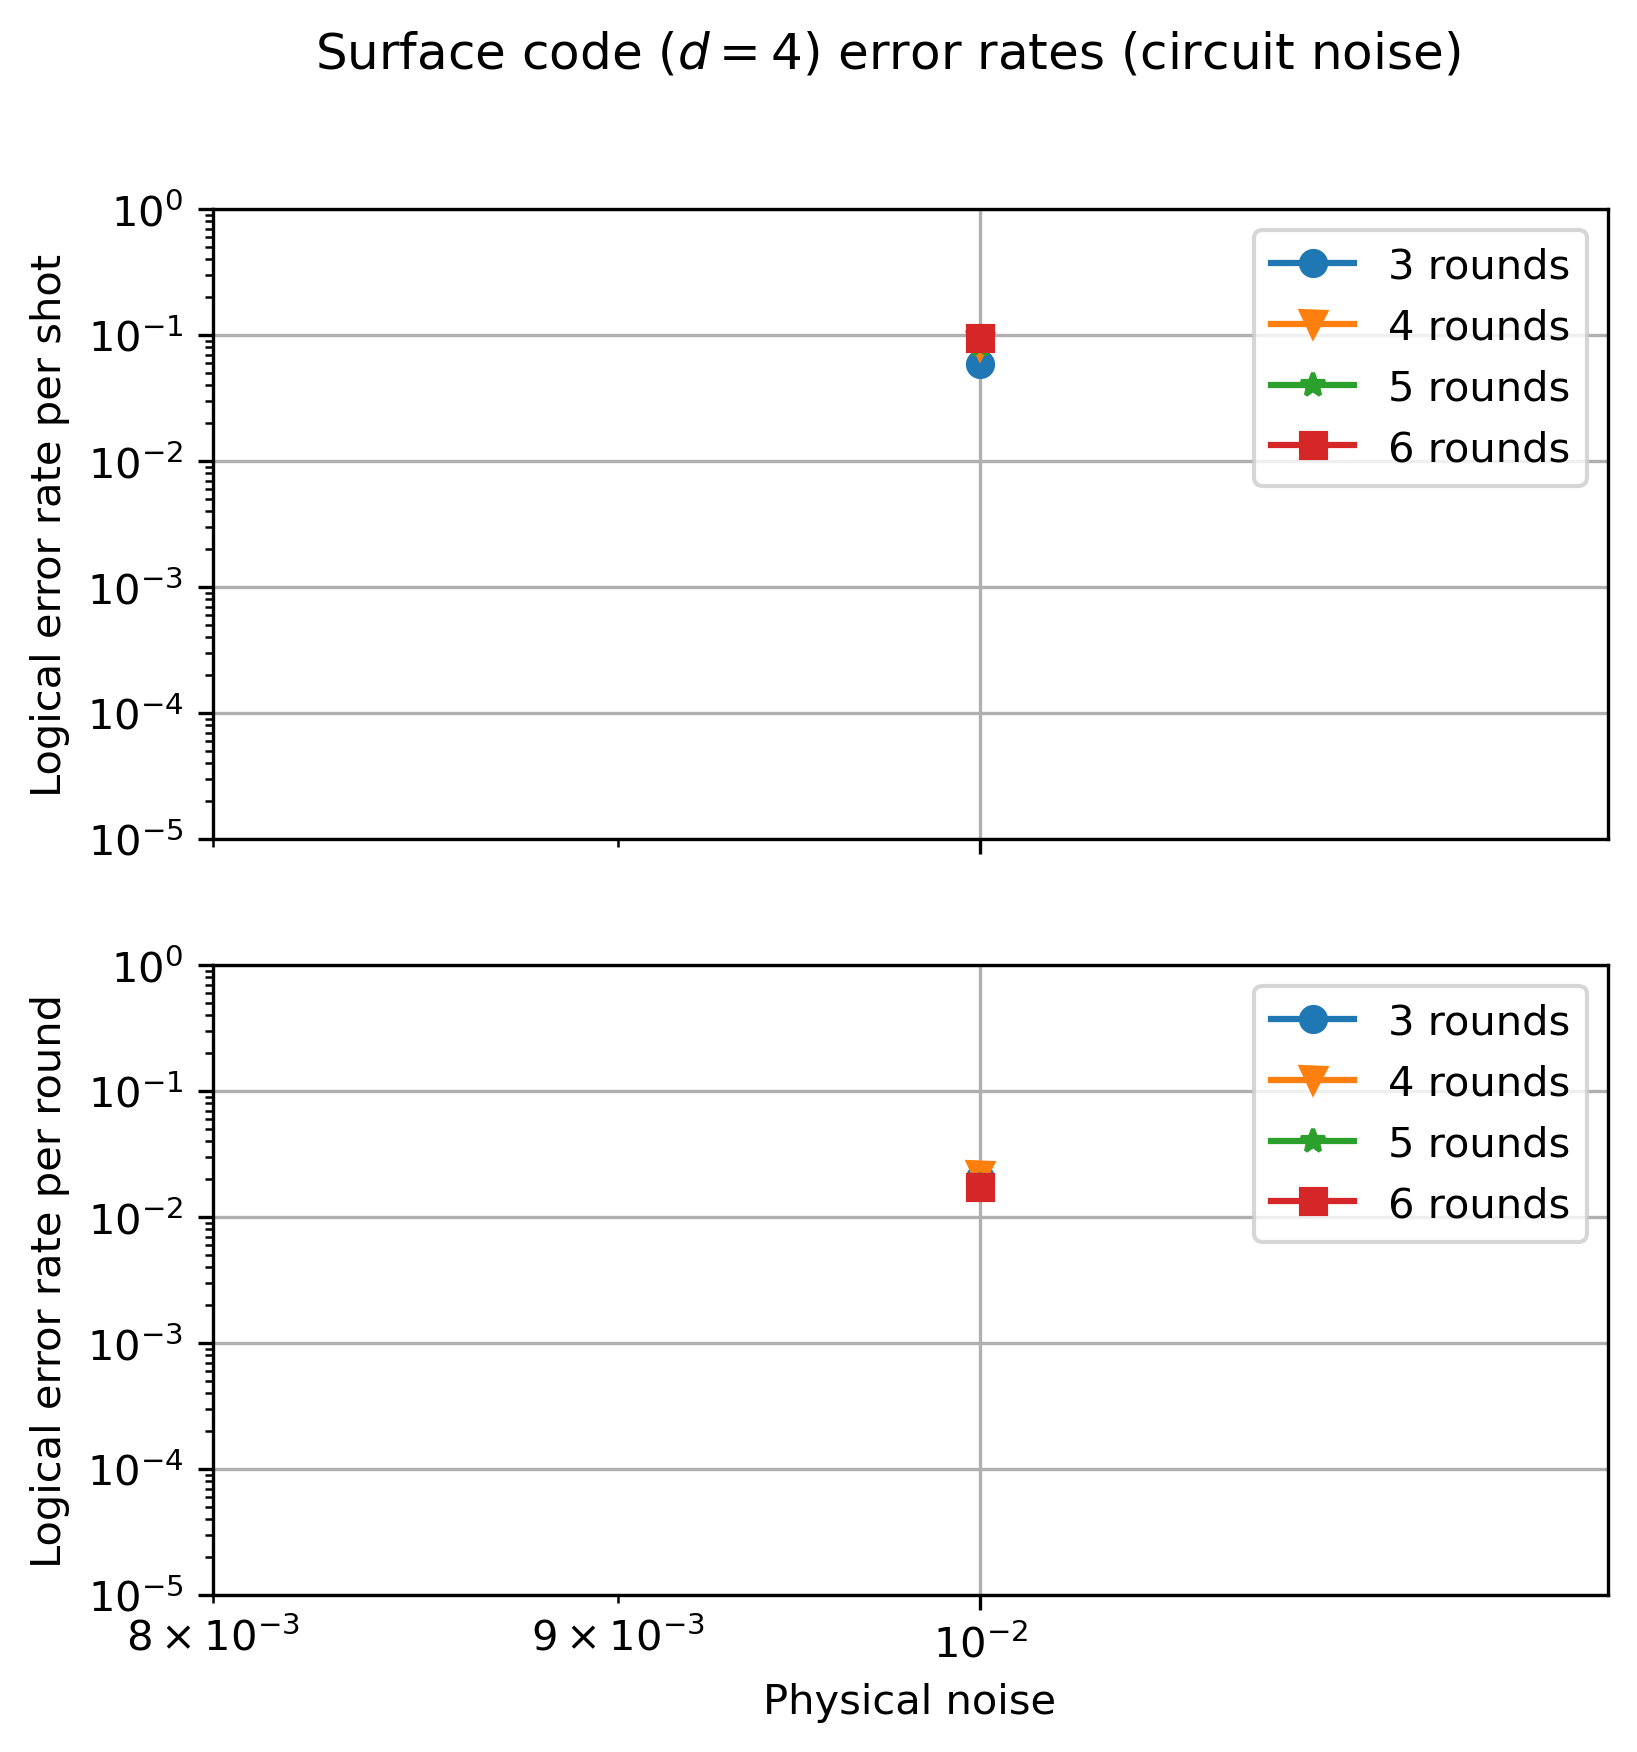

In [3]:
fig, (axl, axr) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
plot_label = "Surface code ($d=4$) error rates (circuit noise)"
group_labels = dict()
for r in rounds:
  group_labels[r] = f"{r} rounds"
plot_error_rate_sinter(
  axl, results, "noise", "Physical noise", "Logical error rate per shot",
  group_title="rounds", group_labels=group_labels,
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.)
)
plot_error_rate_sinter(
  axr, results, "noise", "Physical noise", "Logical error rate per round",
  group_title="rounds", group_labels=group_labels,
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.),
  failure_units_per_shot_func = lambda st, tt="rounds": get_variable_from_sample_sinter(st, tt)
)
axl.label_outer()
axr.label_outer()
fig.suptitle(plot_label)
fig.set_dpi(300)
plot_jupyter_figure(fig)

In [4]:
test_circuits = [ tasks[i].circuit for i in range(len(distances)) ] # No need to remake the circuits, just pick those from the innermost for-loop

In [5]:
from utilities_tf import *
import numpy as np
from copy import deepcopy

2024-09-25 21:29:56.839274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 21:29:56.839386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 21:29:56.839408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 21:29:56.846004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
detector_events = []
actual_flips = []
# The four lists below are for the training and testing data
detector_events_train = []
actual_flips_train = []
detector_events_test = []
actual_flips_test = []
i_noise = 0
for test_circuit in test_circuits:
  sampler = test_circuit.compile_detector_sampler(seed=12345)
  measurements = sampler.sample(n_samples, separate_observables=True, bit_packed=True)
  det_evts, flips = measurements  
  detector_events.append(det_evts)
  actual_flips.append(flips)
  print("Number of flips in the circuit for noise probability p={}: {} / {} = {}".format(noise_levels[i_noise], np.sum(flips.reshape(-1,)), flips.shape[0], np.sum(flips.reshape(-1,))/flips.shape[0]))

  # Split the data into training and testing sets
  # Changed positional arguments arrays and flips to two different arrays for array unpacking
  det_evts_train, det_evts_test, flips_train, flips_test = split_data(det_evts, flips, test_size=0.2)
  detector_events_train.append(det_evts_train)
  actual_flips_train.append(flips_train)
  detector_events_test.append(det_evts_test)
  actual_flips_test.append(flips_test)

Number of flips in the circuit for noise probability p=0.01: 1866756 / 10000000 = 0.1866756
Number of flips in the circuit for noise probability p=0.01: 2766616 / 10000000 = 0.2766616
Number of flips in the circuit for noise probability p=0.01: 3546244 / 10000000 = 0.3546244
Number of flips in the circuit for noise probability p=0.01: 4134923 / 10000000 = 0.4134923


In [7]:
measurements

(array([[ 72,   0, 160, ...,   0,   0,   0],
        [ 32, 128, 110, ...,   0, 161,   0],
        [ 16,   0,   0, ...,   0,   0,   0],
        ...,
        [ 16, 160,  40, ...,   2,  96,   0],
        [  2,  20, 192, ...,   0,   0,   0],
        [ 16,  34, 128, ...,   8,  18,   0]], dtype=uint8),
 array([[0],
        [1],
        [0],
        ...,
        [0],
        [1],
        [0]], dtype=uint8))

In [8]:
for evt in detector_events:
    print(evt.shape)

(10000000, 3)
(10000000, 8)
(10000000, 15)
(10000000, 27)


In [9]:
from tensorflow.keras.models import load_model
models_dense = []
saved = False
if not saved:
    for i in range(len(distances)):
      models_dense.append(
        build_sequential_dense_model(
          detector_events[i].shape[1], actual_flips[i].shape[1],
          [256, 256, 128, 64, 32],
          loss_fcn = "binary_crossentropy"
        )
      )
else:
    for i in range(len(distances)):
        models_dense.append(load_model(f'model_d={distances[i]}_r={rounds[i]}.keras'))

2024-09-25 21:30:34.391224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-25 21:30:34.413317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-25 21:30:34.413685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 110081 (430.00 KB)
Trainable params: 11008

In [10]:
detector_events_train[0]

array([[ 18,   4,   4],
       [192,   4,   0],
       [ 64,  80,   0],
       ...,
       [ 70,   0,   0],
       [  0, 129,   1],
       [  0,  64,  38]], dtype=uint8)

In [11]:
if not saved:
    for i in range(len(distances)):
      print(f"Training the model with Dense layers for d={distances[i]} r={rounds[i]}")
      history = models_dense[i].fit(detector_events_train[i], actual_flips_train[i], epochs=25 - 5*i, batch_size=100000, validation_split=0.2)
      test_model(models_dense[i], detector_events_train[i], actual_flips_train[i], detector_events_test[i], actual_flips_test[i])

Training the model with Dense layers for d=3 r=3
Epoch 1/25


2024-09-25 21:30:36.491928: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-25 21:30:36.947969: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faa017a42f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-25 21:30:36.948083: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 4g.40gb, Compute Capability 8.0
2024-09-25 21:30:36.954874: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-25 21:30:36.969670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-09-25 21:30:37.083489: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 4s 18ms/step - loss: 0.6229 - accuracy: 0.7999 - val_loss: 0.4758 - val_accuracy: 0.8118
Epoch 2/25
64/64 [==============================] - 1s 16ms/step - loss: 0.4174 - accuracy: 0.8126 - val_loss: 0.3978 - val_accuracy: 0.8136
Epoch 3/25
64/64 [==============================] - 1s 16ms/step - loss: 0.3943 - accuracy: 0.8136 - val_loss: 0.3945 - val_accuracy: 0.8134
Epoch 4/25
64/64 [==============================] - 1s 16ms/step - loss: 0.3868 - accuracy: 0.8148 - val_loss: 0.3840 - val_accuracy: 0.8150
Epoch 5/25
64/64 [==============================] - 1s 17ms/step - loss: 0.3824 - accuracy: 0.8160 - val_loss: 0.3782 - val_accuracy: 0.8161
Epoch 6/25
64/64 [==============================] - 1s 16ms/step - loss: 0.3802 - accuracy: 0.8163 - val_loss: 0.3730 - val_accuracy: 0.8273
Epoch 7/25
64/64 [==============================] - 1s 16ms/step - loss: 0.3712 - accuracy: 0.8256 - val_loss: 0.3707 - val_accuracy: 0.8270
Epoch 8/25
64/64 [======

In [12]:
for model in models_dense:
    model.save(f'model_d={distances[i]}_r={rounds[i]}.keras', overwrite=True)

In [13]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 10:
    return 0.001*(10-epoch)
  elif epoch < 20:
    return lr * 0.9
  elif epoch < 30:
    return lr * 0.8
  else:
    return lr * 0.65

In [14]:
from types_cfg import get_types
from circuit_partition import split_measurements


kernel_size = 3

idxs_test, idxs_train = split_data(np.arange(n_samples, dtype=np.int32), test_size = 1/2, seed = 12345, shuffle = False)

rcnn_bits = []
rcnn_evts = []
rcnn_flippies = []

idx = 0

for test_circuit in test_circuits:
    d = distances[idx]
    r = rounds[idx]
    i+=1
    binary_t, time_t, idx_t, packed_t = get_types(d, r, kernel_size)
    call_split_measurements = lambda measurements, d=d, idx_t=idx_t: split_measurements(measurements, d, idx_t)
    idxs_test, idxs_train = split_data(np.arange(n_samples, dtype=np.int32), test_size = 1/2, seed = 12345, shuffle = False)
    m_sampler = test_circuit.compile_sampler(seed=12345)
    d_sampler = test_circuit.compile_detector_sampler(seed=12345)
    converter = test_circuit.compile_m2d_converter()
    detector_error_model = test_circuit.detector_error_model(decompose_errors=True)
    measurements = m_sampler.sample(n_samples, bit_packed=False)
    rcnn_det_evts, rcnn_flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
    measurements = measurements.astype(binary_t)
    rccn_det_evts = rcnn_det_evts.astype(binary_t)
    rcnn_det_evts = rcnn_det_evts.astype('int8')
    rcnn_flips = rcnn_flips.astype(binary_t)


    rcnn_det_bits, _, _ = call_split_measurements(measurements)

    rcnn_evts.append(rccn_det_evts)
    rcnn_bits.append(rcnn_det_bits)
    rcnn_flippies.append(rcnn_flips)

    avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
    print(f"Average flip rate for the full circuit: {avg_flips}")

Average flip rate for the full circuit: 0.4134923
Average flip rate for the full circuit: 0.4134923
Average flip rate for the full circuit: 0.4134923
Average flip rate for the full circuit: 0.4134923


In [15]:
from CNNModel import *

use_rotated_z = True
observable_type = "ZL" if use_rotated_z else "XL"

rcnn_models = []

n_nodes = 100
for i in range(len(distances)):
    d = distances[i]
    r = rounds[i]
    model_dxd = FullRCNNModel(
      observable_type, d, kernel_size, r,
      [n_nodes for _ in range(2)],
      npol=2,
      stop_round = None,
      has_nonuniform_response = False,
      do_all_data_qubits = False,
      return_all_rounds = False
    )
    model_dxd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_dxd([ rcnn_bits[i][0:1], rcnn_evts[i][0:1] ])
    model_dxd.summary()
    rcnn_models.append(model_dxd)

Number of unique contributions: 9
Total number of fractions: 0
Total number of phases: 0
Total number of inverters: 0
Number of unique contributions: 9
Total number of fractions: 0
Total number of phases: 0
Total number of inverters: 0
Number of unique contributions: 9
Total number of fractions: 0
Total number of phases: 0
Total number of inverters: 0
Model: "full_rcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state_decoder (StateDecode  multiple                  11201     
 r)                                                              
                                                                 
 rcnn_initial_state_kernel_  multiple                  1926      
 combiner (RCNNInitialState                                      
 KernelCombiner)                                                 
                                                                 
 rcnn_lead_in_kernel_combin

In [ ]:
val_split = 0.2
n_epochs = 25
if not saved: 
    for i in range(len(distances)):
        history = rcnn_models[i].fit(
          x=[ rcnn_bits[i][idxs_train], rcnn_evts[i][idxs_train] ],
          y=rcnn_flippies[i][idxs_train,:],
          batch_size=10000,
          epochs=n_epochs - 5*i, validation_split=val_split,
          callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
          ]
        )
        rcnn_models[i].save_weights(f"{saved_data_dir}/model_dxd_d={distances[i]}_r={rounds[i]}", overwrite=True)
        save_history(history, f"{saved_data_dir}/history_d={distances[i]}_r={rounds[i]}.root")
else:
    for i in range(len(distances)):
        rcnn_models[i].load_weights(f"{saved_data_dir}/model_dxd_d={distances[i]}_r={rounds[i]}")

Epoch 1/25
400/400 [==============================] - 31s 38ms/step - loss: 0.5107 - accuracy: 0.8136 - val_loss: 0.4815 - val_accuracy: 0.8133 - lr: 0.0100
Epoch 2/25
400/400 [==============================] - 13s 31ms/step - loss: 0.4809 - accuracy: 0.8136 - val_loss: 0.4815 - val_accuracy: 0.8133 - lr: 0.0090
Epoch 3/25
400/400 [==============================] - 13s 32ms/step - loss: 0.4809 - accuracy: 0.8136 - val_loss: 0.4815 - val_accuracy: 0.8133 - lr: 0.0080
Epoch 4/25
400/400 [==============================] - 13s 32ms/step - loss: 0.4809 - accuracy: 0.8136 - val_loss: 0.4815 - val_accuracy: 0.8133 - lr: 0.0070
Epoch 5/25
400/400 [==============================] - 12s 31ms/step - loss: 0.4809 - accuracy: 0.8136 - val_loss: 0.4815 - val_accuracy: 0.8133 - lr: 0.0060
Epoch 6/25
400/400 [==============================] - 13s 31ms/step - loss: 0.4809 - accuracy: 0.8136 - val_loss: 0.4815 - val_accuracy: 0.8133 - lr: 0.0050
Epoch 7/25
400/400 [==============================] - 13s 

In [ ]:
'''
from tensorflow.keras.models import load_model
model_0 = load_model('Archive/models_dense_0.keras')
model_1 = load_model('Archive/models_dense_1.keras')
model_2 = load_model('Archive/models_dense_2.keras')
model_3 = load_model('Archive/models_dense_3.keras')

models_dense = [model_0, model_1, model_2, model_3]
'''

In [ ]:
import hls4ml
from hls4ml.backends.vivado.vivado_backend import VivadoBackend
hls_models = []
i = 0 
for model in models_dense:
    dense_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
    hls_model = hls4ml.converters.convert_from_keras_model(
        model, hls_config=dense_config, output_dir=f'test_models/hls4ml_dense_{i}'
        )
    hls_model.build(reset=False, csim=True, synth=False, cosim=False, validation=False, export=False, vsynth=False, fifo_opt=False)
    hls_model.compile()
    hls_models.append(hls_model)
    i+=1

In [ ]:
def predict_hls(model, features, labels):
  """
  Get the predictions of a model on a given dataset.
  - Arguments:
    model: Model
    data: Data to predict
  - Return type:
    Numpy array
  """
  n_data = labels.shape[0]
  n_flips = np.sum(labels.reshape(-1,) != 0)
  n_unflips = np.sum(labels.reshape(-1,) == 0)
# HLS does not accept batch sizes on predict
  prediction = model.predict(features)
  prediction = (prediction>0)
  matches = (prediction != labels)
  matches_flipped = matches*(labels != 0)
  matches_unflipped = matches*(labels == 0)
  n_matches = np.sum(matches)
  n_matches_flipped = np.sum(matches_flipped)
  n_matches_unflipped = np.sum(matches_unflipped)
  print(f"Prediction accuracy: {1.0 - n_matches/n_data:.6f}")
  print(f"- Flipped/unflipped accuracies: {1.0 - n_matches_flipped/n_flips:.6f} / {1.0 -n_matches_unflipped/n_unflips:.6f}")

  return prediction

In [ ]:
for i in range(len(distances)):
    print(f"Sequential model with Dense layers (d={distances[i]} r={rounds[i]}):")
    predict_model(models_dense[i], detector_events[i], actual_flips[i])
for i in range(len(distances)):
    print(f"RCNN model with custom layers (d={distances[i]} r={rounds[i]}):")
    flips_pred = rcnn_models[i].predict(
  [ rcnn_bits[i][idxs_test], rcnn_evts[i][idxs_test] ],
  batch_size=10000
    )
    print(f"Inaccuracy of the final model on the test data: {(rcnn_flips[idxs_test]!=(flips_pred>0.5).astype(binary_t)).astype(binary_t).sum()/idxs_test.shape[0]}")

In [ ]:
flips_pred

In [ ]:
# Test single input on hls model for timing

In [ ]:
print(f"HLS model with Dense layers (p={noise_levels[i]}):")
predict_hls(hls_models[i], detector_events[i].astype('float32'), actual_flips[i])

In [ ]:
for i in range(len(distances)):
    models_dense[i].summary()